<a href="https://colab.research.google.com/github/sahanas0/LEGO_ErrorDetection/blob/main/Latest_LEGOErrorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %% Global Parameters (Add this as the very first cell in your notebook)

# --- Global Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 5 # Initial epochs for head training
FINE_TUNE_EPOCHS = 15 # Additional epochs for fine-tuning
CLASSIFICATION_THRESHOLD = 0.7 # Your optimal threshold for classification

# --- Paths ---
DATA_ROOT_ZIP = '/content/drive/MyDrive/dataset.zip' # Path to your zipped dataset on Google Drive
LOCAL_DATASET_DIR = 'dataset' # Local folder where zip contents will be extracted
LOCAL_SPLIT_DIR = 'dataset_split' # Local folder for train/test splits
MODEL_SAVE_PATH = '/content/drive/MyDrive/lego_error_model.h5' # Path to save/load your model on Google Drive

# --- Grad-CAM Specific Layer Names (defined here for global access) ---
BASE_MODEL_LAYER_NAME = 'mobilenetv2_1.00_224' # Name of the MobileNetV2 layer within your model
LAST_CONV_LAYER_NAME_IN_BASE = 'Conv_1' # Name of the last conv layer *within* MobileNetV2

print("✅ Global parameters defined.")

✅ Global parameters defined.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/dataset.zip'

import zipfile

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')  # Extract to local Colab folder
print("✅ Dataset extracted from Drive.")


✅ Dataset extracted from Drive.


In [ ]:
import os
print(os.listdir())  # List contents of the current working directory

['.config', 'drive', 'dataset', 'sample_data']


In [ ]:
import os

for root, dirs, files in os.walk('dataset'):
    print(f"{root} has {len(files)} files")


dataset has 0 files
dataset/dataset has 0 files
dataset/dataset/bad has 207 files
dataset/dataset/good has 207 files


In [ ]:
!pip install imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
# %% Cell 7: Duplicate Removal

import imagehash
from PIL import Image
from collections import defaultdict

categories = ['bad', 'good']

def remove_duplicates_by_hash(directory, threshold=0):
    for category in categories:
        hash_dict = []
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            print(f"Warning: Category path does not exist: {category_path}. Skipping duplicate removal for this category.")
            continue
        images = os.listdir(category_path)
        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img_hash = imagehash.average_hash(img)
            except Exception as e:
                print(f"❌ Failed to process {img_name}: {e}")
                continue
            duplicate_found = False
            for existing_hash, existing_path in hash_dict:
                if abs(existing_hash - img_hash) <= threshold:
                    duplicate_found = True
                    break
            if duplicate_found:
                os.remove(img_path)
            else:
                hash_dict.append((img_hash, img_path))
    print("✅ Duplicate removal complete.")

# --- Determine the actual directory containing 'good' and 'bad' folders ---
# This handles cases where the zip extracts into a nested folder (e.g., dataset/dataset)
actual_dataset_content_dir = LOCAL_DATASET_DIR
if len(os.listdir(LOCAL_DATASET_DIR)) == 1 and os.path.isdir(os.path.join(LOCAL_DATASET_DIR, os.listdir(LOCAL_DATASET_DIR)[0])):
    actual_dataset_content_dir = os.path.join(LOCAL_DATASET_DIR, os.listdir(LOCAL_DATASET_DIR)[0])

# Call duplicate removal BEFORE splitting
remove_duplicates_by_hash(actual_dataset_content_dir, threshold=0)


✅ Duplicate removal complete.


In [ ]:
# %% Cell 8: Data Splitting

import os
import shutil
import random

original_dir = actual_dataset_content_dir # Use the determined content directory
output_dir = LOCAL_SPLIT_DIR # Use the global LOCAL_SPLIT_DIR
categories = ['bad', 'good'] # Make sure categories is defined or imported if not global
train_ratio = 0.8

for split in ['train', 'test']:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

for category in categories:
    image_list = os.listdir(os.path.join(original_dir, category))
    random.shuffle(image_list)
    split_index = int(len(image_list) * train_ratio)
    train_images = image_list[:split_index]
    test_images = image_list[split_index:]

    for img in train_images:
        shutil.copyfile(os.path.join(original_dir, category, img),
                        os.path.join(output_dir, 'train', category, img))
    for img in test_images:
        shutil.copyfile(os.path.join(original_dir, category, img),
                        os.path.join(output_dir, 'test', category, img))

print("✅ Data split into train/test folders.")

for root, dirs, files in os.walk(output_dir):
    print(f"{root} has {len(files)} files")


✅ Data split into train/test folders.
dataset_split has 0 files
dataset_split/test has 0 files
dataset_split/test/bad has 42 files
dataset_split/test/good has 42 files
dataset_split/train has 0 files
dataset_split/train/bad has 165 files
dataset_split/train/good has 165 files


In [ ]:
from collections import Counter

train_images = []
test_images = []

for category in categories:
    train_path = os.path.join(output_dir, 'train', category)
    test_path = os.path.join(output_dir, 'test', category)
    train_images += [os.path.join('train', category, img) for img in os.listdir(train_path)]
    test_images += [os.path.join('test', category, img) for img in os.listdir(test_path)]

duplicates = set(train_images) & set(test_images)
print(f"Number of duplicates between train and test: {len(duplicates)}")


Number of duplicates between train and test: 0


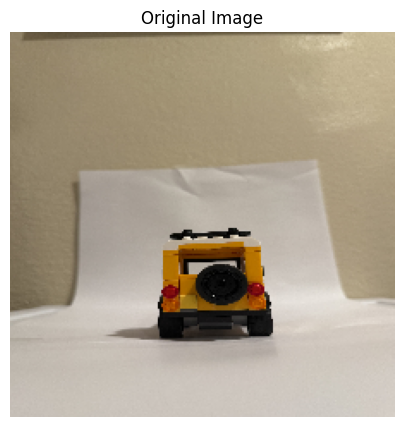

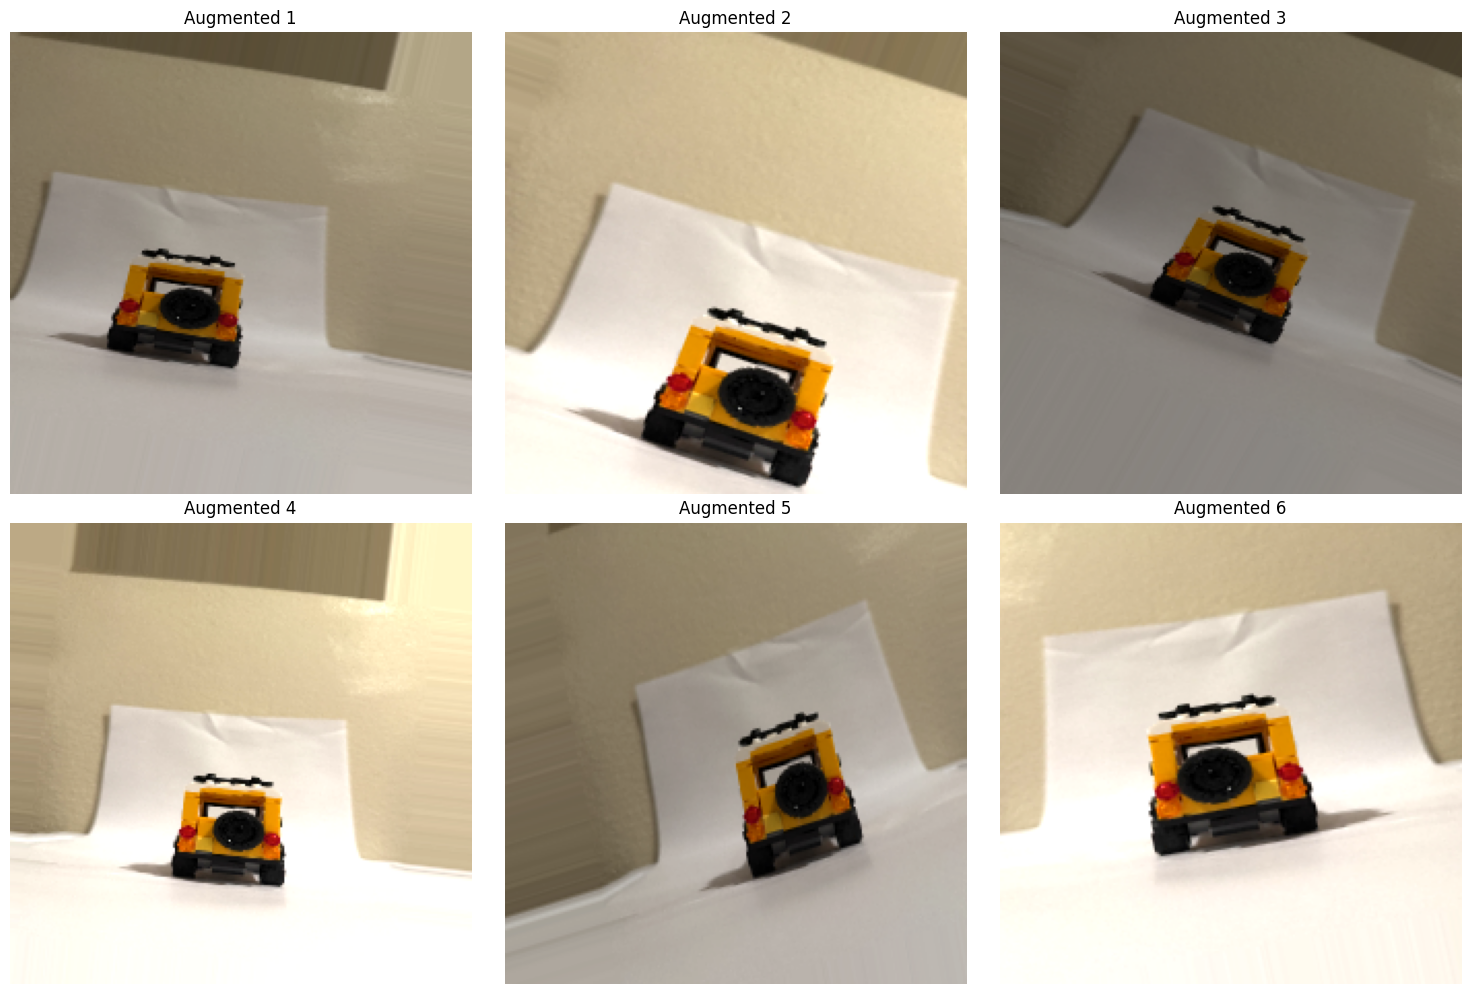

In [ ]:
# ------VISUALIZE AUGMENTATION ----------
# %% Cell 10: Visualize Augmentation

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf # Make sure tf is imported

# Set paths (using global LOCAL_SPLIT_DIR)
category = "good"
subset = "train"

# Load a sample image
sample_dir = os.path.join(LOCAL_SPLIT_DIR, subset, category) # Use LOCAL_SPLIT_DIR
sample_image_name = os.listdir(sample_dir)[0]
sample_image_path = os.path.join(sample_dir, sample_image_name)

# Load and display original image
original_img = load_img(sample_image_path, target_size=IMG_SIZE) # Use global IMG_SIZE
plt.figure(figsize=(5,5))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Convert to array for augmentation
x = img_to_array(original_img)
x = np.expand_dims(x, axis=0)

# Define a temporary augmentation generator for visualization (should match your training one)
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    #channel_shift_range=80.0 # Example value for noticeable shift
)

# Generate and display augmented images
aug_iter = datagen.flow(x, batch_size=1)

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    batch = next(aug_iter)
    img = batch[0]
    img = ((img + 1) * 127.5).astype(np.uint8)
    plt.imshow(img)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [ ]:
# %% New Cell 11: Model Definition, Training, and Saving

# --- Imports (consolidated for model training) ---
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model # load_model is crucial here
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os # For os.path.exists

# --- Data Generators (these need to be defined here if not in a prior common cell) ---
# Assuming train_gen and val_gen are needed from Cell 1. If not, they need to be re-defined here.
# For simplicity, I'll put the generator definitions here.
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    #channel_shift_range=80.0
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(LOCAL_SPLIT_DIR, "train"), # Use global LOCAL_SPLIT_DIR
    target_size=IMG_SIZE, # Use global IMG_SIZE
    batch_size=BATCH_SIZE, # Use global BATCH_SIZE
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(LOCAL_SPLIT_DIR, "train"), # Use global LOCAL_SPLIT_DIR
    target_size=IMG_SIZE, # Use global IMG_SIZE
    batch_size=BATCH_SIZE, # Use global BATCH_SIZE
    class_mode="binary",
    subset="validation",
    shuffle=False
)
print("✅ Data Generators (train_gen, val_gen) are ready.")


# --- Model Load/Train Logic ---
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Model found at '{MODEL_SAVE_PATH}'. Loading model...")
    model = load_model(MODEL_SAVE_PATH)
    print("✅ Model loaded successfully. No retraining needed.")
else:
    print(f"No model found at '{MODEL_SAVE_PATH}'. Training a new model...")

    # ✅ Build model with L2 regularization
    base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False # Freeze the base model for initial training

    inputs = Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # ✅ Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    print("--- Starting initial training of the classification head (base model frozen) ---")
    history = model.fit(
        train_gen,
        epochs=EPOCHS, # Use global EPOCHS
        validation_data=val_gen,
        callbacks=[early_stop]
    )

    # Store initial training history for combined plots
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    print("--- Initial training complete. Now starting fine-tuning ---")

    # --- FINE-TUNING SECTION ---
    base_model.trainable = True # Unfreeze the base model

    # Unfreeze a portion of the base model (e.g., last ~20-50 layers)
    fine_tune_from_layer = 100 # Example: Unfreeze layers from index 100 onwards
    for layer in base_model.layers[:fine_tune_from_layer]:
        layer.trainable = False

    # Recompile the model with a much lower learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    print(f"Fine-tuning for {FINE_TUNE_EPOCHS} additional epochs...")
    history_fine_tune = model.fit(
        train_gen,
        epochs=EPOCHS + FINE_TUNE_EPOCHS, # Total epochs
        initial_epoch=history.epoch[-1],
        validation_data=val_gen,
        callbacks=[early_stop]
    )

    # Append fine-tuning history to initial history for combined plots
    acc += history_fine_tune.history['accuracy']
    val_acc += history_fine_tune.history['val_accuracy']
    loss += history_fine_tune.history['loss']
    val_loss += history_fine_tune.history['val_loss']

    # --- Plotting Training History ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(), plt.title('Combined Accuracy'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(), plt.title('Combined Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

    # --- Save the trained model to Google Drive ---
    model.save(MODEL_SAVE_PATH) # Use global MODEL_SAVE_PATH
    print(f"✅ Model saved to {MODEL_SAVE_PATH}")


Found 264 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
✅ Data Generators (train_gen, val_gen) are ready.
Model found at '/content/drive/MyDrive/lego_error_model.h5'. Loading model...


✅ Model loaded successfully. No retraining needed.


Found 84 images belonging to 2 classes.

--- Evaluating on the separate Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8388 - loss: 1.3992
Test Loss: 1.3134
Test Accuracy: 0.8810
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step

Classification Report (Test Set) with threshold=0.7:
              precision    recall  f1-score   support

         bad       0.89      0.93      0.91        42
        good       0.93      0.88      0.90        42

    accuracy                           0.90        84
   macro avg       0.91      0.90      0.90        84
weighted avg       0.91      0.90      0.90        84



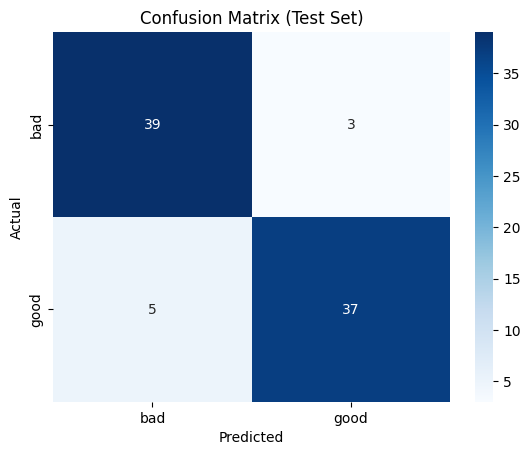

Accuracy (Test Set): 0.9048
Precision (Test Set): 0.9250
Recall (Test Set): 0.8810
F1 Score (Test Set): 0.9024

--- Average Confidence Score Analysis (Test Set) ---

Average Confidence by Predicted Class (Threshold=0.7):
Average Confidence when Predicted 'Good': 0.9403
Average Confidence when Predicted 'Bad': 0.8149

Average Confidence for Correct Predictions (Threshold=0.7):
Avg Conf (True Positive - Actual Good, Predicted Good): 0.9448
Avg Conf (True Negative - Actual Bad, Predicted Bad): 0.8199

Average Confidence for Incorrect Predictions (Threshold=0.7):
Avg Conf (False Positive - Actual Bad, Predicted Good): 0.8844
Avg Conf (False Negative - Actual Good, Predicted Bad): 0.7758


In [ ]:
# %% New Cell 12: Evaluation on Test Set

# --- Imports (consolidated for evaluation) ---
import numpy as np # Already imported, but good to ensure
import matplotlib.pyplot as plt # Already imported, but good to ensure
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import os # For os.path.join


# Create a generator for the 'test' set
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(LOCAL_SPLIT_DIR, "test"), # Use global LOCAL_SPLIT_DIR
    target_size=IMG_SIZE, # Use global IMG_SIZE
    batch_size=BATCH_SIZE, # Use global BATCH_SIZE
    class_mode="binary",
    shuffle=False # Important for consistent evaluation
)

print("\n--- Evaluating on the separate Test Set ---")
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

test_preds = model.predict(test_gen)

# --- Define the threshold for Test Set Evaluation ---
# Use the global CLASSIFICATION_THRESHOLD defined in Cell 1
threshold_for_report = CLASSIFICATION_THRESHOLD # Renamed to avoid confusion if you were using 'threshold' locally

y_pred_test = [int(p > threshold_for_report) for p in test_preds.flatten()]
y_true_test = test_gen.classes

print(f"\nClassification Report (Test Set) with threshold={threshold_for_report}:")
print(classification_report(y_true_test, y_pred_test, target_names=['bad', 'good']))

cm_test = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy (Test Set): {accuracy_score(y_true_test, y_pred_test):.4f}")
print(f"Precision (Test Set): {precision_score(y_true_test, y_pred_test):.4f}")
print(f"Recall (Test Set): {recall_score(y_true_test, y_pred_test):.4f}")
print(f"F1 Score (Test Set): {f1_score(y_true_test, y_pred_test):.4f}")


# --- Average Confidence Score Calculation Block ---
# Derive predicted labels based on the CLASSIFICATION_THRESHOLD
y_pred_test_thresholded = [int(p > threshold_for_report) for p in test_preds.flatten()]

print("\n--- Average Confidence Score Analysis (Test Set) ---")

# 1. Overall Average Confidence for each class (based on model's prediction)
avg_conf_predicted_good = np.mean(test_preds[np.array(y_pred_test_thresholded) == 1])
avg_conf_predicted_bad = np.mean(1 - test_preds[np.array(y_pred_test_thresholded) == 0])

print(f"\nAverage Confidence by Predicted Class (Threshold={threshold_for_report}):")
print(f"Average Confidence when Predicted 'Good': {avg_conf_predicted_good:.4f}")
print(f"Average Confidence when Predicted 'Bad': {avg_conf_predicted_bad:.4f}")


# 2. Average Confidence for Correctly Classified Instances (True Positives, True Negatives)
true_pos_indices = (np.array(y_true_test) == 1) & (np.array(y_pred_test_thresholded) == 1)
avg_conf_true_pos = np.mean(test_preds[true_pos_indices]) if np.any(true_pos_indices) else 0

true_neg_indices = (np.array(y_true_test) == 0) & (np.array(y_pred_test_thresholded) == 0)
avg_conf_true_neg = np.mean(1 - test_preds[true_neg_indices]) if np.any(true_neg_indices) else 0

print(f"\nAverage Confidence for Correct Predictions (Threshold={threshold_for_report}):")
print(f"Avg Conf (True Positive - Actual Good, Predicted Good): {avg_conf_true_pos:.4f}")
print(f"Avg Conf (True Negative - Actual Bad, Predicted Bad): {avg_conf_true_neg:.4f}")


# 3. Average Confidence for Incorrectly Classified Instances (False Positives, False Negatives)
false_pos_indices = (np.array(y_true_test) == 0) & (np.array(y_pred_test_thresholded) == 1)
avg_conf_false_pos = np.mean(test_preds[false_pos_indices]) if np.any(false_pos_indices) else 0

false_neg_indices = (np.array(y_true_test) == 1) & (np.array(y_pred_test_thresholded) == 0)
avg_conf_false_neg = np.mean(1 - test_preds[false_neg_indices]) if np.any(false_neg_indices) else 0

print(f"\nAverage Confidence for Incorrect Predictions (Threshold={threshold_for_report}):")
print(f"Avg Conf (False Positive - Actual Bad, Predicted Good): {avg_conf_false_pos:.4f}")
print(f"Avg Conf (False Negative - Actual Good, Predicted Bad): {avg_conf_false_neg:.4f}")


Please upload your images (you can select multiple files):


Saving IMG_2015.jpg to IMG_2015.jpg
Saving IMG_2031.jpg to IMG_2031.jpg
Saving IMG_2049.jpg to IMG_2049.jpg
Saving IMG_2051.jpg to IMG_2051.jpg
Saving IMG_2113.jpg to IMG_2113.jpg

Processing 5 images...


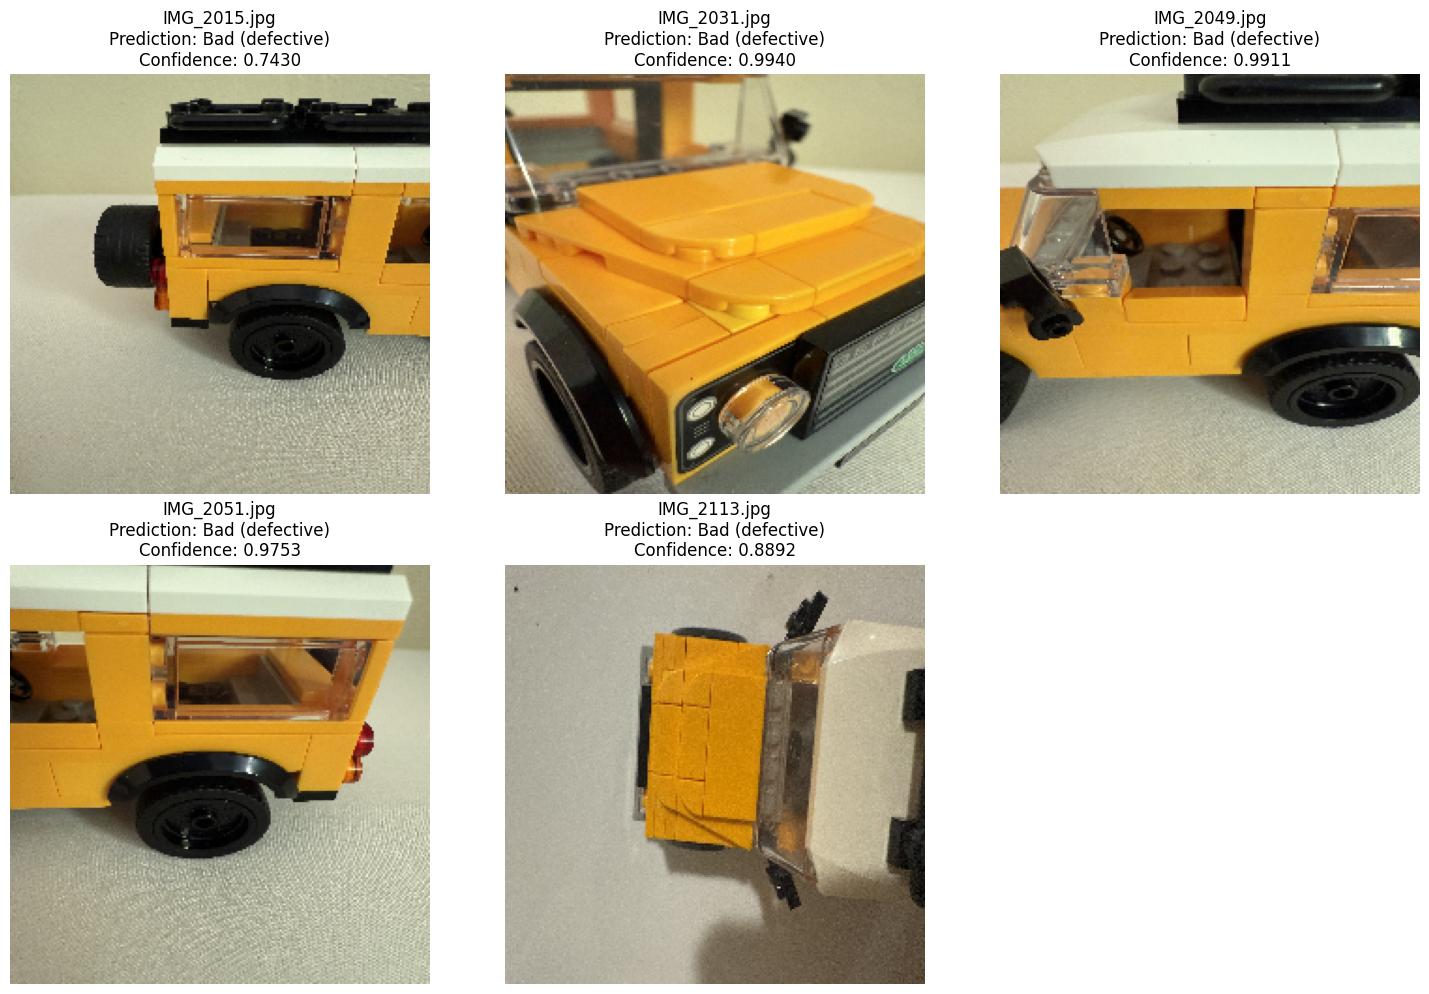


--- Average Confidence Score Analysis (for uploaded images) ---
No images were predicted as 'Good'.
Average Confidence when predicted 'Bad': 0.9185


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict # To store predictions for each image name


# Assuming your 'model', 'IMG_SIZE' are already defined and loaded


print("Please upload your images (you can select multiple files):")
uploaded_files = files.upload()


# Define your classification threshold (adjust this to your optimal value, e.g., 0.7)
CLASSIFICATION_THRESHOLD = 0.7


# Lists to store data for average confidence calculations
all_good_probabilities = []
all_predicted_labels = [] # 0 for bad, 1 for good
all_filenames = [] # To keep track of which prediction belongs to which file


# Create a figure to display all images
# Adjust figure size dynamically based on the number of images (3 columns per row)
num_images = len(uploaded_files)
num_rows = (num_images + 2) // 3 # Calculate rows needed for 3 columns
plt.figure(figsize=(15, 5 * num_rows))


print(f"\nProcessing {num_images} images...")


for i, (filename, file_content) in enumerate(uploaded_files.items()):
   # Save the uploaded file temporarily (needed by image.load_img)
   with open(filename, 'wb') as f:
       f.write(file_content)


   # Load and preprocess image
   img_path = filename
   img = image.load_img(img_path, target_size=IMG_SIZE)
   img_array = image.img_to_array(img)
   img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
   img_array = preprocess_input(img_array) # Preprocess for MobileNetV2


   # Predict
   prediction_raw = model.predict(img_array, verbose=0) # verbose=0 to suppress per-image output
   good_probability = prediction_raw[0][0]


   # Apply your chosen classification threshold
   predicted_label = 1 if good_probability > CLASSIFICATION_THRESHOLD else 0 # 1 for good, 0 for bad
   class_label_str = "Good (no defect)" if predicted_label == 1 else "Bad (defective)"


   # Store results for later average confidence calculation
   all_good_probabilities.append(good_probability)
   all_predicted_labels.append(predicted_label)
   all_filenames.append(filename)


   # Determine confidence for the displayed class
   if predicted_label == 1: # It's "Good (no defect)"
       confidence_score = good_probability
   else: # It's "Bad (defective)"
       confidence_score = 1.0 - good_probability # Confidence for 'bad' is 1 - prob_good


   # Display results for each image
   plt.subplot(num_rows, 3, i + 1) # Arrange in a grid
   plt.imshow(img)
   plt.title(f"{filename}\nPrediction: {class_label_str}\nConfidence: {confidence_score:.4f}")
   plt.axis('off')


plt.tight_layout()
plt.show()


# Optional: Clean up temporary files
# import os
# for filename in uploaded_files.keys():
#     os.remove(filename)
# print("Temporary files cleaned up.")




# --- Calculation of Average Confidence Scores ---
print("\n--- Average Confidence Score Analysis (for uploaded images) ---")


# Convert lists to NumPy arrays for easier manipulation
all_good_probabilities_np = np.array(all_good_probabilities)
all_predicted_labels_np = np.array(all_predicted_labels)


# 1. Average Confidence for all images predicted as 'Good'
predicted_good_probs = all_good_probabilities_np[all_predicted_labels_np == 1]
if len(predicted_good_probs) > 0:
   avg_conf_predicted_good = np.mean(predicted_good_probs)
   print(f"Average Confidence when predicted 'Good': {avg_conf_predicted_good:.4f}")
else:
   print("No images were predicted as 'Good'.")


# 2. Average Confidence for all images predicted as 'Bad'
predicted_bad_probs = all_good_probabilities_np[all_predicted_labels_np == 0]
if len(predicted_bad_probs) > 0:
   # Confidence for 'bad' is 1 - probability of 'good'
   avg_conf_predicted_bad = np.mean(1 - predicted_bad_probs)
   print(f"Average Confidence when predicted 'Bad': {avg_conf_predicted_bad:.4f}")
else:
   print("No images were predicted as 'Bad'.")


# --- IMPORTANT: If you know the TRUE labels of these 5 images ---
# You can manually input them here to get more insightful metrics (True/False Positives/Negatives)
# Example: If the first 3 were truly 'bad' (0) and the last 2 were truly 'good' (1)
# true_labels_for_uploaded_images = np.array([0, 0, 0, 1, 1]) # <--- REPLACE WITH YOUR ACTUAL TRUE LABELS


# If you have true labels, uncomment the following block:
# if 'true_labels_for_uploaded_images' in locals():
#     print("\n--- Detailed Confidence Analysis (with True Labels) ---")
#
#     # True Positives (Actual Good, Predicted Good)
#     true_pos_indices = (true_labels_for_uploaded_images == 1) & (all_predicted_labels_np == 1)
#     avg_conf_true_pos = np.mean(all_good_probabilities_np[true_pos_indices]) if np.any(true_pos_indices) else 0
#     print(f"Avg Conf (True Positive - Actual Good, Predicted Good): {avg_conf_true_pos:.4f}")
#
#     # True Negatives (Actual Bad, Predicted Bad)
#     true_neg_indices = (true_labels_for_uploaded_images == 0) & (all_predicted_labels_np == 0)
#     avg_conf_true_neg = np.mean(1 - all_good_probabilities_np[true_neg_indices]) if np.any(true_neg_indices) else 0
#     print(f"Avg Conf (True Negative - Actual Bad, Predicted Bad): {avg_conf_true_neg:.4f}")
#
#     # False Positives (Actual Bad, Predicted Good)
#     false_pos_indices = (true_labels_for_uploaded_images == 0) & (all_predicted_labels_np == 1)
#     avg_conf_false_pos = np.mean(all_good_probabilities_np[false_pos_indices]) if np.any(false_pos_indices) else 0
#     print(f"Avg Conf (False Positive - Actual Bad, Predicted Good): {avg_conf_false_pos:.4f}")
#
#     # False Negatives (Actual Good, Predicted Bad)
#     false_neg_indices = (true_labels_for_uploaded_images == 1) & (all_predicted_labels_np == 0)
#     avg_conf_false_neg = np.mean(1 - all_good_probabilities_np[false_neg_indices]) if np.any(false_neg_indices) else 0
#     print(f"Avg Conf (False Negative - Actual Good, Predicted Bad): {avg_conf_false_neg:.4f}")